In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("stc TV Data Set_T2.csv")

In [ ]:
df.shape

(86, 3)

In [ ]:
df.head()

,Unnamed: 0,date_,Total_watch_time_in_houres
0,0,2018-01-01 00:00:00,1123.551944
1,1,2018-01-02 00:00:00,1000.129722
2,2,2018-01-03 00:00:00,881.924444
3,3,2018-01-04 00:00:00,782.669444
4,4,2018-01-05 00:00:00,1051.939444


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  86 non-null     int64  
 1   date_                       86 non-null     object 
 2   Total_watch_time_in_houres  86 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
df.describe()

,Unnamed: 0,Total_watch_time_in_houres
count,86.000000,86.000000
mean,42.500000,780.817926
std,24.969982,122.992002
min,0.000000,562.124722
25%,21.250000,707.709653
50%,42.500000,763.181389
75%,63.750000,840.985278
max,85.000000,1123.551944


In [ ]:
df.isnull().any()

,0
Unnamed: 0,False
date_,False
Total_watch_time_in_houres,False


In [ ]:
# تأكد من اسم العمود الخاص بالوقت (ممكن يكون date_ أو غيره)
df['date_'] = pd.to_datetime(df['date_'], errors='coerce')

In [ ]:
# إجمالي المشاهدات اليومية
daily = df.groupby('date_')['Total_watch_time_in_houres'].sum().reset_index()

In [ ]:
# Prophet يحتاج عمود ds (للتاريخ) و y (للقيمة)
daily = daily.rename(columns={'date_':'ds', 'Total_watch_time_in_houres':'y'})

In [ ]:
print("Prepared Data:")
print(daily.head())

Prepared Data:
          ds            y
0 2018-01-01  1123.551944
1 2018-01-02  1000.129722
2 2018-01-03   881.924444
3 2018-01-04   782.669444
4 2018-01-05  1051.939444


In [ ]:
# Build & fit the Prophet model
model = Prophet()
model.fit(daily)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp38if5bgs/ka_ms2xz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp38if5bgs/z0x6oxfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99471', 'data', 'file=/tmp/tmp38if5bgs/ka_ms2xz.json', 'init=/tmp/tmp38if5bgs/z0x6oxfn.json', 'output', 'file=/tmp/tmp38if5bgs/prophet_modelicxnlbar/prophet_model-20250925123040.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:30:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:30:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Forecast next 60 days
future = model.make_future_dataframe(periods=60)  # 60 days = شهرين تقريبا
forecast = model.predict(future)

In [ ]:
#Clean negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

In [ ]:
# آخر تاريخ في البيانات الأصلية
last_date = daily['ds'].max()

# فلترة التوقعات الجديدة فقط
future_forecast = forecast[forecast['ds'] > last_date]

print("Future forecast (next 60 days):")
print(future_forecast[['ds','yhat','yhat_lower','yhat_upper']].head(10))  # أول 10 أيام تنبؤ


Future forecast (next 60 days):
           ds        yhat  yhat_lower  yhat_upper
86 2018-05-01  641.705760  521.045615  760.254330
87 2018-05-02  622.752681  502.149327  733.587109
88 2018-05-03  624.402900  500.768918  739.613666
89 2018-05-04  650.397382  534.295764  786.931909
90 2018-05-05    0.000000    0.000000    0.000000
91 2018-05-06    0.000000    0.000000    0.000000
92 2018-05-07  638.672639  519.675185  755.649187
93 2018-05-08  625.758790  502.656745  738.516271
94 2018-05-09  606.805711  490.776527  722.479815
95 2018-05-10  608.455930  495.846764  715.610296


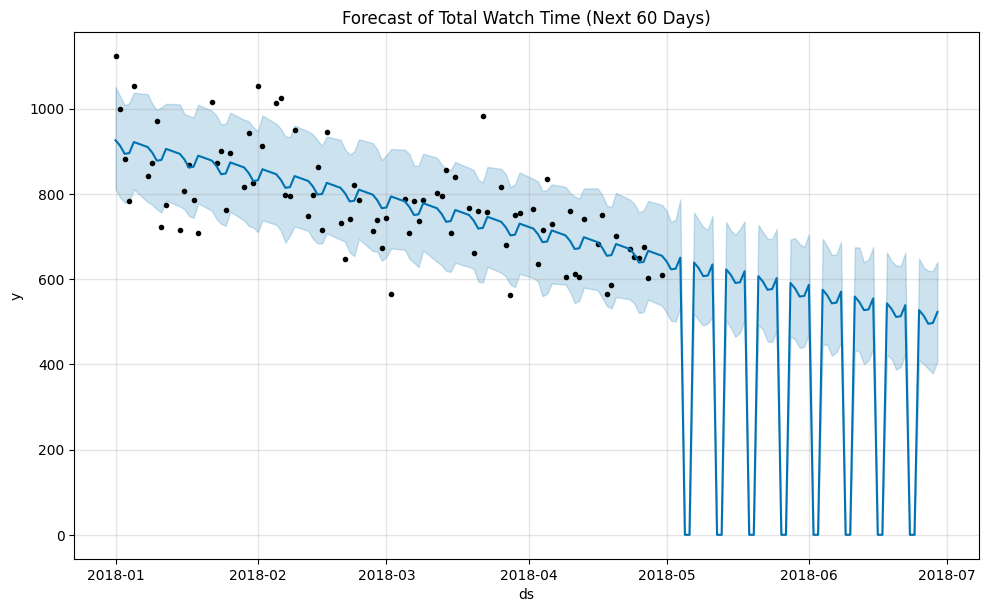

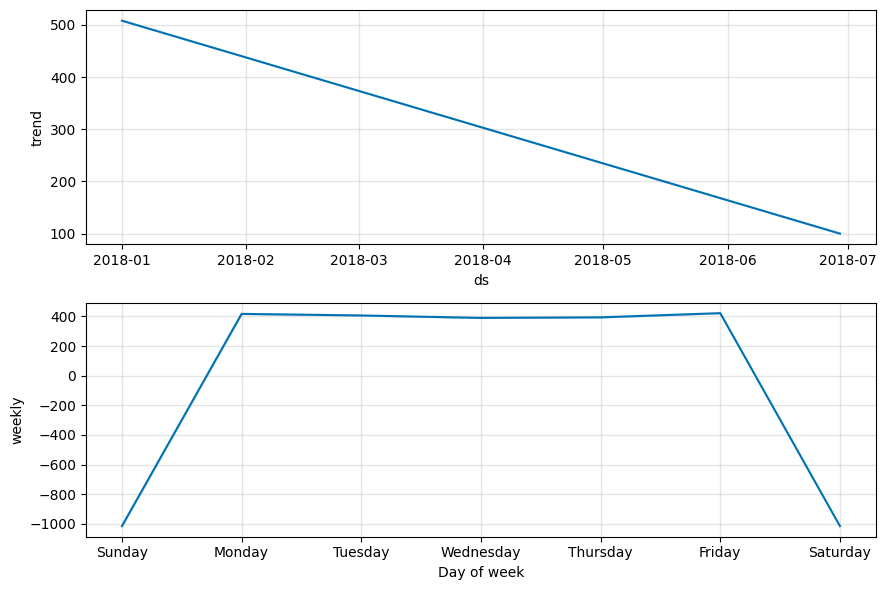

In [ ]:
fig1 = model.plot(forecast)
plt.title("Forecast of Total Watch Time (Next 60 Days)")
plt.show()

# Step 6: Plot forecast components (trend + seasonality)
fig2 = model.plot_components(forecast)
plt.show()


In [ ]:
daily = daily.rename(columns={'date_':'ds', 'Total_watch_time_in_houres':'y'})

# بعد ما تعملي التنبؤ بالـ Prophet
future_forecast = forecast[forecast['ds'] > daily['ds'].max()]

# إضافة عمود يوم الأسبوع
future_forecast['day_of_week'] = future_forecast['ds'].dt.day_name()

# حساب متوسط المشاهدة المتوقعة لكل يوم
peak_days = future_forecast.groupby('day_of_week')['yhat'].mean().reset_index()

# ترتيب الأيام من الأعلى للأقل
peak_days = peak_days.sort_values(by='yhat', ascending=False)

print("Predicted peak days (next 60 days):")
print(peak_days)


Predicted peak days (next 60 days):
  day_of_week        yhat
0      Friday  586.609503
1      Monday  582.858244
5     Tuesday  577.917880
4    Thursday  560.615020
6   Wednesday  558.964801
2    Saturday    0.000000
3      Sunday    0.000000


/tmp/ipython-input-941969724.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['day_of_week'] = future_forecast['ds'].dt.day_name()
